# Rejection Sampling

Is a type of exact simulation method. The method works for any distribution in $\mathbf{R}^n$ with a PDF.

Rejection sampling is based on the observation that to sample a random variable in one dimension, one can perform a uniformly random sampling of the two-dimensional Cartesian graph, and keep the samples in the region under the graph of its density function.

First we need a source of random numbers uniformly distributed between 0 and 1.
Given a source of random numbers with such a uniform distribution, we can easily produce a random sequence
with an arbitrary distribution.
Suppose we have a positive function $f(x)$ on the unit interval and we wish to generate points with a weighting proportional to
$f$.
For simplicity assume $f$ is bounded; if not, make a change of variables to make it so.
Without loss of generality, we assume $f(x)$ us bounded by unity.
Using the given random number generator, we obtains a trial number for the first element of our weighted sequence.
Calling this number $x$, we obtain a second random number and accept $x$ if the new random variable is less than $f(x)$.
This is repeated many times to form a sequence of accepted values of $x$.
As the probability of accepting any $x$ is proportional to $f(x)$, the sequence has the desired weighting.

From "Quarks, Gluons, and Lattice", page 132.

Later on below, we will visit the more formal definiton by Casella.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [3]:
%load_ext memory_profiler

In [4]:
%%timeit # -r 7 -n 1_000
s = np.random.uniform(0, 1, 100_000)

420 µs ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [5]:
%%memit
# see
# https://github.com/pythonprofilers/memory_profiler/blob/a99a3c3b3c2eb01c90f6e14ddfcb85b3e97f9885/memory_profiler.py#L1029
s = np.random.uniform(0, 1, 100_000)

peak memory: 105.44 MiB, increment: 0.12 MiB


In [6]:
%memit np.random.uniform(0, 1, 100)

peak memory: 105.44 MiB, increment: 0.00 MiB


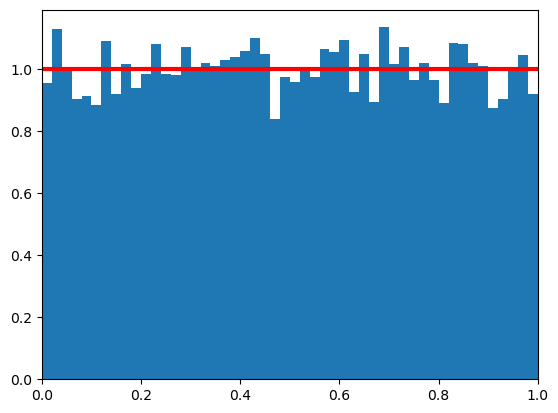

In [2]:
# Plot a uniform distribution.
s = np.random.uniform(0, 1, 10_000)

count, bins, ignored = plt.hist(s, 50, density=True)

plt.plot(bins, np.ones_like(bins), linewidth=3, color='r')
plt.xlim(0, 1)
plt.show()

approximations accepted: 1441
0.1% percentile: -3.090, 99.9% percentile: 3.090


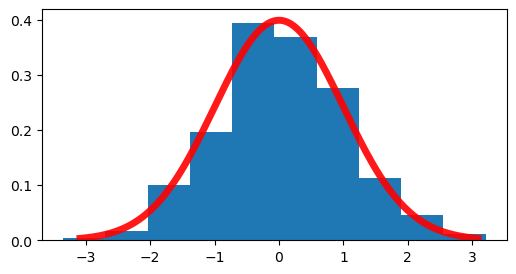

In [4]:
# Simple implementation of the rejection sampling algorithm.
n = 10_000
samples = np.random.uniform(-3.5, 3.5, n)
acceptances = np.random.uniform(0, 1, n)
normalize = 3.5 - -3.5

approximations = []
for i in range(len(samples)):
    x = samples[i]
    f_u = scipy.stats.norm.pdf(x)
        
    if acceptances[i] < f_u:
        approximations.append(x)


print(f"approximations accepted: {len(approximations)}")
print(f"0.1% percentile: {scipy.stats.norm.ppf(0.001):0.3f}, 99.9% percentile: {scipy.stats.norm.ppf(0.999):0.3f}")

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

x = np.linspace(scipy.stats.norm.ppf(0.001), scipy.stats.norm.ppf(0.999), 200)
ax.plot(x, scipy.stats.norm.pdf(x), 'r-', lw=5, alpha=0.9, label="norm pdf")

ax.hist(approximations, bins=10, density=True)

#ax.legend(loc='best', frameon=False)
fig.show()

In [5]:
# Now try generating random variates for some generic function f().
import random

def f(x):
    """Target distribution (proportional to): f(x) = x^2."""
    return x ** 2

def rejection_sampling(num_samples, func):
    """Generates samples from a distribution proportional to f(x) on [0, 1] using rejection sampling."""
    samples = []
    
    while len(samples) < num_samples:
        # Generate a trial sample x from a uniform distribution
        x = random.uniform(0, 1)
        # Generate a second random number for acceptance
        accept_prob = random.uniform(0, 1)
        
        # Accept x if the second random number is less than f(x)
        if accept_prob < func(x):
            samples.append(x)
    
    return samples

# Example usage:
num_samples = 10000
samples = rejection_sampling(num_samples, f)
print(f"Generated {len(samples)} samples.")

Generated 10000 samples.


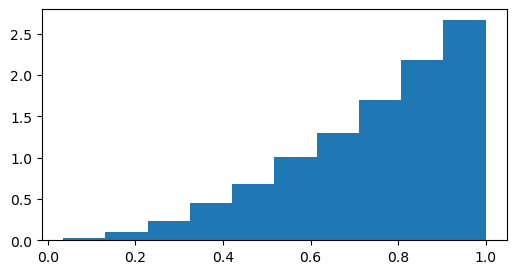

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.hist(samples, bins=10, density=True)

fig.show()

Generated 100000 samples.


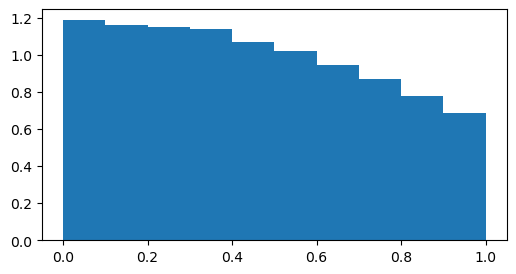

In [7]:
# Example usage: using a cosine distribution.
num_samples = 100000
samples = rejection_sampling(num_samples, np.cos)
print(f"Generated {len(samples)} samples.")

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.hist(samples, bins=10, density=True)

fig.show()

Casella gives more rigour to our topic.
It all starts out by thinking of $f$ as our density of interest.
On an arbitrary state, we can say that

$$
f(x) = \int_{0}^{f(x)} du
$$

This way of writing it makes $f$ be the **marginal density** in $X$ of of the joint distribution

$$
(X, U) \sim \mathbf{U} \{ 0 < u < f(x) \}
$$

This in practice means that to simulate $X \sim f$, when
$$
\int_{a}^{b} f(x) = 1
$$
we can $Y \sim \mathbf{U}(a,b)$ and $U|Y = y \sim \mathbf{U}(0,m)$, where $m$ is the bound of $f$.
Note that $U|Y = y \sim \mathbf{U}(0,m)$ should be read as "generate $U$ given that $Y=y$" - like $U|(Y = y) \sim \mathbf{U}(0,m)$.

So the whole process is just to figure out the domain of $f$ and and its range ($m$), and use those
bits of info to generate two sets of uniform random variates.
Then we take $X = Y$ when $0 < u \leq f(y)$.
Think of this last statement of as follows: we accept $u$ to be a point within our target distribution only if it is below where the curve $f$ would be ($u \leq f(y)$).

In [2]:
import numpy as np
import scipy.stats
import functools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [5]:
def target_beta_dist(x):
    # Parameters for the beta distribution
    alpha = 2.7
    beta = 6.3

    # https://en.wikipedia.org/wiki/Beta_distribution
    # The mode is the point where the density will be the highest (m).
    #mode = (alpha - 1) / (alpha + beta - 2)
    
    # Calculate the maximum density value at the mode.
    return scipy.stats.beta.pdf(x, alpha, beta)

In [97]:
# We generate the data points ahead of time because we cannot animate a scatterplot by adding one point
# per frame. The matplotlib-way to go about it is to instead create a scatterplot, and within that scatterplot
# we can change the size of all points, their locations, or the color. Note that we cannot change the markers being used.
# we will show how to do that below by creating two scatterplots, one using 'o's and the other '^'s.
iterations = 50 * 30

y = np.random.uniform(0, 1, iterations)
u = np.random.uniform(0, 2.67, iterations)
f_y = np.array([target_beta_dist(xi) for xi in y])

# This array is for keeping track of all the u points we did accept.
#points = [u_val if u_val <= f_y_val else f_y_val for u_val, f_y_val in zip(u, f_y) ]

# The 'red' or 'black' values here match the indices of the accepted and rejected points.
colors = ["red" if u_val <= f_y_val else "black" for u_val, f_y_val in zip(u, f_y) ]

# Because we need to use the scatterplot method set_offsets() to update the scatterplot,
# it turns out to be simples to use np.vstack().T to merge the (x,y) arrays
# (the y random variates and the u random variates), and then transpose them into an n x 2 array.
vstack = np.vstack((y, u)).T

In [99]:
fig = plt.figure()
plt.xlim(0, 1)
plt.ylim(0, 2.7)
#graph, = plt.plot([], [], 'o') # another way of creating an empty plot.
graph = plt.scatter([], [])

def animate(i, graph):
    # Note the way we are "skipping frames" here, we will improve upon this on the next animation.
    i = i*30
    
    graph.set_offsets( vstack[:i+1] )
    graph.set_facecolors(colors[:i+1])
    return graph


anim = functools.partial(animate, graph=graph)
ani = animation.FuncAnimation(fig, anim, frames=50)

# Output generated via `matplotlib.animation.Animation.to_jshtml`.
plt.close(fig) # Used to prevent the PNG from showing.
# TODO: delete the next line. we are commenting out because otherwise
# the notebook will be too large and github won't render it.
#HTML(ani.to_jshtml())

In [29]:
# Some chatgpt suggested improvements...
y = np.random.uniform(0, 1, 5)
u = np.random.uniform(0, 2.67, 5)

alpha = 2.7
beta = 6.3
def target_beta_dist(x, a, b):
    return scipy.stats.beta.pdf(x, a, b)

target_dist = functools.partial(target_beta_dist, a=alpha, b=beta)

f_y = np.array([target_dist(xi) for xi in y])

print(u)
print(f_y)
test_accepted = np.where(u <= f_y)
print(test_accepted)
test_accepted[0].shape

[2.38145174 0.15632661 0.72902444 0.52879026 1.77322837]
[1.28184264 1.16960212 0.79794234 0.63064744 2.44689877]
(array([1, 2, 3, 4]),)


(4,)

In [30]:
# Select specific values from the indices of accepted values only if the index meets
# the condition that it is less than 3.
test_accepted[0][test_accepted[0] < 3]

array([1, 2])

In [31]:
iterations = 5_000
nth = 100


# https://en.wikipedia.org/wiki/Beta_distribution
# The mode is the point where the density will be the highest (m).
mode = (alpha - 1) / (alpha + beta - 2)
max_density = target_dist(mode)

y = np.random.uniform(0, 1, iterations)
u = np.random.uniform(0, max_density, iterations)
f_y = np.array([target_dist(xi) for xi in y])

accepted_indices = np.where(u <= f_y)[0]
rejected_indices = np.where(u > f_y)[0]

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, round(max_density, 1))

accepted_scatter = ax.scatter([], [], marker='^', color='green', s=10)
rejected_scatter = ax.scatter([], [], marker='o', color='red', s=10)

def init():
    accepted_scatter.set_offsets(np.empty((0, 2)))  # Corrected here
    rejected_scatter.set_offsets(np.empty((0, 2)))  # Corrected here
    return accepted_scatter, rejected_scatter,

def animate(i):
    end_idx = min((i + 1) * nth, iterations)
    
    acc_idx = accepted_indices[accepted_indices < end_idx]
    rej_idx = rejected_indices[rejected_indices < end_idx]
    
    accepted_scatter.set_offsets(np.vstack((y[acc_idx], u[acc_idx])).T)
    rejected_scatter.set_offsets(np.vstack((y[rej_idx], u[rej_idx])).T)
    
    return accepted_scatter, rejected_scatter,

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=iterations // nth, blit=True, interval=50)

plt.close(fig)  # Prevents duplicate output
# TODO: delete the next line. we are commenting out because otherwise
# the notebook will be too large and github won't render it.
#HTML(ani.to_jshtml())

In [8]:
# Acceptance rate.
accepted_indices.size / iterations

0.3696

In [9]:
mode

0.24285714285714288

Now the generalization of the rejection sampling algorithm!

In this case, we sample $Y$ not as $\mathbf{U}$ but following our proposed distribution $g$, $Y \sim g$.
And $U | Y=y \sim \mathbf{U}(0, Mg(y))$.
And if $0 < u \leq f(y) \leq Mg(y)$, then we accept $u$.

Note that $\mathbf{U}(0, Mg(y))$ is $\mathbf{U}(0,1)$ scaled by $Mg(y)$.

The last point, in particular, is why the acceptance rule for this algorithm is often written as
$$
U \leq f(X) / M g(X)
$$
when $X \sim g$ and $U \sim \mathbf{U}(0,1)$.

---

Note that $1/M$ can be seen as a geometric waiting time because the [Geometric distribution](https://en.wikipedia.org/wiki/Geometric_distribution) is the number of trials we have to wait for a success, which is defined as
$$
P(X = k) = \left( 1 - \frac{1}{M} \right)^{k-1} \frac{1}{M}
$$

If we want a success right away, then the chance of it is simply $p = 1/M$.
COincidentally, the mean of the geometric distribution is $1/p$, hence the expected number of trials until a variable is accepted is $M$.

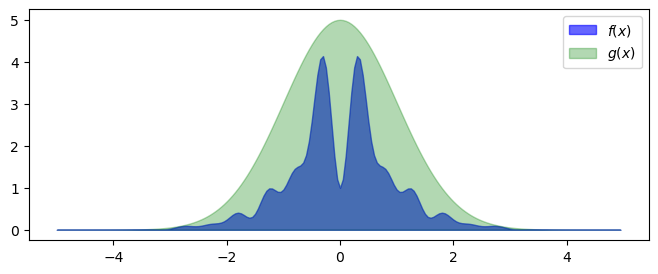

In [4]:
def example_f(x):
    return np.exp(-np.square(x)/2) * (
            np.square(np.sin(6*x))
            + 3 * np.square(np.cos(x)) * np.square(np.sin(4*x))
            + 1
        )

def example_g(x):
    return 5 * np.exp( -np.square(x)/2 )

fig, ax = plt.subplots(figsize=(8, 3))

section = np.arange(-5, 5, 1/20.)

ax.fill_between(section, example_f(section), color='blue', alpha=0.6, label='$f(x)$')
ax.fill_between(section, example_g(section), color='green', alpha=0.3, label='$g(x)$')

ax.legend()
plt.show()

In [39]:
iterations = 1000
nth = 100

# Multiplying by 5 only increases the height, not the width of the gaussian curve.
# So generating with a standard normal is ok.
Y = np.random.normal(loc=0, scale=1, size=iterations)

# Compute g(Y) for all generated Y.
gY = example_g(Y)

# Generate U uniformly from [0, g(Y)] for each Y.
U = np.random.uniform(low=0, high=gY, size=iterations)

# Apply the acceptance criterion (U <= f(Y)).
accepted_indices = U <= example_f(Y)
X = Y[accepted_indices]  # Filter Y values that meet the criterion.

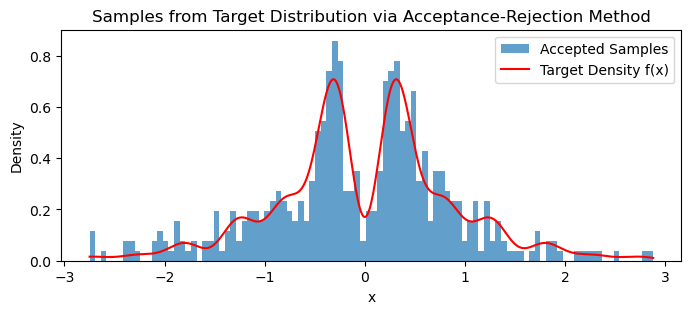

In [40]:
plt.figure(figsize=(8, 3))

plt.hist(X, bins=100, density=True, alpha=0.7, label='Accepted Samples')

x_values = np.linspace(min(X), max(X), 1000)
plt.plot(x_values, example_f(x_values)/np.trapz(example_f(x_values), x_values), label='Target Density f(x)', color='red')

plt.legend()
plt.title('Samples from Target Distribution via Acceptance-Rejection Method')
plt.xlabel('x')
plt.ylabel('Density')
plt.show()

In [12]:
# Generate samples and apply the acceptance criterion as before
n_samples = 100
bins = 100

Y = np.random.normal(loc=0, scale=1, size=n_samples)
U = np.random.uniform(low=0, high=example_g(Y), size=n_samples)
accepted = U <= example_f(Y)
X_accepted = Y[accepted]

# Prepare the figure and axis for the animation, including initial histogram
fig, ax = plt.subplots(figsize=(8, 4))
_, _, _ = ax.hist(X_accepted, bins=bins, density=True, alpha=0.7, label='Accepted Samples')
ax.set_xlim(-5, 5)
ax.set_ylim(0, 1)
ax.set_title('Sampling from Target Distribution via Acceptance-Rejection')
ax.set_xlabel('x')
ax.set_ylabel('Density')
line, = ax.plot([], [], label='Target Density f(x)', color='red')  # Placeholder for the target density line
ax.legend()

# Normalizing factor for target density f(x) for plotting
x_values = np.linspace(-5, 5, 400)
f_norm = example_f(x_values) / np.trapz(example_f(x_values), x_values)

def animate(i):
    local_n_samples = n_samples + i*50

    Y = np.random.normal(loc=0, scale=1, size=local_n_samples)
    U = np.random.uniform(low=0, high=example_g(Y), size=local_n_samples)
    accepted = U <= example_f(Y)
    X_accepted = Y[accepted]
    
    # Update histogram with more samples
    ax.clear()
    ax.hist(X_accepted, bins=bins, density=True, alpha=0.7, label='Accepted Samples')
    ax.plot(x_values, f_norm, label='Target Density f(x)', color='red')
    ax.set_xlim(-5, 5)
    ax.set_ylim(0, 1)
    
    ax.set_title(f'Sampling from Target Distribution via Acceptance-Rejection\nSamples: {local_n_samples}')
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.legend()

ani = animation.FuncAnimation(fig, animate, frames=100, repeat=False)

plt.close()  # Prevents duplicate static plot under the animation

# Display the animation in the notebook
# TODO: delete the next line. we are commenting out because otherwise
# the notebook will be too large and github won't render it.
#HTML(ani.to_jshtml())

In [62]:
n_samples = 10_000

Y = np.random.normal(loc=0, scale=1, size=n_samples)
U = np.random.uniform(low=0, high=example_g(Y), size=n_samples)
accepted = U <= example_f(Y)
accepted_indices = np.where(accepted)[0]
rejected_indices = np.where(~accepted)[0]


fig, ax = plt.subplots()
ax.set_xlim(-5, 5)  # Adjust based on your data range
ax.set_ylim(0, 5)  # Adjust based on the maximum of U

accepted_scatter = ax.scatter([], [], marker='.', color='green', s=10)
rejected_scatter = ax.scatter([], [], marker='o', color='red', s=10)
# Placeholder for the text annotation.
sample_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, verticalalignment='top')

def init():
    accepted_scatter.set_offsets(np.empty((0, 2)))
    rejected_scatter.set_offsets(np.empty((0, 2)))
    sample_text.set_text('')
    return accepted_scatter, rejected_scatter, sample_text

def animate(i):
    end_idx = min((i + 1) * nth, iterations)
    
    acc_idx = accepted_indices[accepted_indices < end_idx]
    rej_idx = rejected_indices[rejected_indices < end_idx]
    
    accepted_scatter.set_offsets(np.vstack((Y[acc_idx], U[acc_idx])).T)
    rejected_scatter.set_offsets(np.vstack((Y[rej_idx], U[rej_idx])).T)
    
    # Update the text annotation with the current number of samples
    sample_text.set_text(f'Samples: {end_idx}')
    
    return accepted_scatter, rejected_scatter, sample_text

# Define `nth` and `iterations` based on your specific setup
nth = 50
iterations = 10_000

ani = FuncAnimation(fig, animate, init_func=init, frames=iterations // nth, blit=True, interval=50)

plt.close(fig)  # Prevents duplicate output

# Display the animation in the notebook
# TODO: delete the next line. we are commenting out because otherwise
# the notebook will be too large and github won't render it.
#HTML(ani.to_jshtml())